### Plots showing variant distance from the CDR 

using finalized centrodip calls received on 02/10/2026

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd
from pathlib import Path

ASAT_DIR = Path(
    "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/per_smp_asat_beds"
)

dfs = []

for bed_file in ASAT_DIR.glob("*_asat_arrays.bed"):
    sample = bed_file.name.replace("_asat_arrays.bed", "")

    df = pd.read_csv(
        bed_file,
        sep="\t",
        header=None,
        names=["contig", "start", "end", "chr"]
    )

    df["sample"] = sample
    dfs.append(df)

asat_df = pd.concat(dfs, ignore_index=True)

In [3]:
# Read in list of pairwise distances per chromosome

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr
0,HG03098.1,HG03784.1,0.942968,chr6
1,HG03098.1,NA20752.2,0.974936,chr6
2,HG01978.2,NA19835.1,0.999883,chr6
3,HG00741.1,NA18522.1,0.999869,chr6
4,HG00408.1,HG01496.1,0.606856,chr6


### Convert index file to per chrom beds

In [12]:
import pandas as pd
import os

# Read CDR index
cdr_idx = "/private/groups/migalab/jmmenend/HPRC/cenSatProject/CDR_data/hprc_ont_centrodip_output_data_index.csv"
cdr_idx_df = pd.read_csv(cdr_idx, usecols=["sample_id", "haplotype", "centrodip_final"])
cdr_idx_df["sample"] = cdr_idx_df["sample_id"] + "." + cdr_idx_df["haplotype"].astype(str)

# Build contig -> (sample, chr) lookup from asat_df
contig_to_sample_chr = {}
for row in asat_df.itertuples(index=False):
    contig_to_sample_chr[row.contig] = (row.sample, row.chr)

# Read CDR beds and assign chr via contig matching
cdr_dfs = []
missing = 0

for row in cdr_idx_df.itertuples(index=False):
    bed_path = row.centrodip_final
    sample = row.sample

    if not os.path.exists(bed_path):
        missing += 1
        continue

    bed = pd.read_csv(bed_path, sep="\t", header=None, usecols=[0, 1, 2],
                       names=["contig", "start", "end"])

    # Keep only contigs that appear in asat_df for this sample
    bed = bed[bed["contig"].isin(contig_to_sample_chr)]
    bed["sample"] = bed["contig"].map(lambda c: contig_to_sample_chr[c][0])
    bed["chr"] = bed["contig"].map(lambda c: contig_to_sample_chr[c][1])

    # Only keep rows where the sample matches
    bed = bed[bed["sample"] == sample]

    if len(bed) > 0:
        cdr_dfs.append(bed)

cdr_df = pd.concat(cdr_dfs, ignore_index=True)
print(f"Missing bed files: {missing}")
print(f"CDR entries: {len(cdr_df)}, samples: {cdr_df['sample'].nunique()}")
cdr_df.head()


Missing bed files: 0
CDR entries: 24353, samples: 462


,contig,start,end,sample,chr
0,HG00408#1#CM085953.1,94210740,94247231,HG00408.1,chr2
1,HG00408#1#CM085953.1,94311015,94424909,HG00408.1,chr2
2,HG00408#1#CM085953.1,94534722,94570044,HG00408.1,chr2
3,HG00408#1#CM085957.1,45265389,45460611,HG00408.1,chr8
4,HG00408#1#CM085961.1,34995842,35018738,HG00408.1,chr16


In [16]:
### Verify all chrom contigs are present in centrodip beds
sample_to_bed = dict(zip(cdr_idx_df["sample"], cdr_idx_df["centrodip_final"]))

# Cache bed files to avoid re-reading the same file for every contig
bed_cache = {}

results = []
for row in asat_df[["sample", "contig", "chr"]].itertuples(index=False):
    sample, contig, chrom = row.sample, row.contig, row.chr
    bed_path = sample_to_bed.get(sample)

    if bed_path is None:
        results.append((sample, contig, chrom, "no_cdr_idx_entry"))
    elif not os.path.exists(bed_path):
        results.append((sample, contig, chrom, "bed_file_missing"))
    else:
        if bed_path not in bed_cache:
            bed_cache[bed_path] = set(
                pd.read_csv(bed_path, sep="\t", header=None, usecols=[0], names=["contig_in_bed"])["contig_in_bed"]
            )
        if contig in bed_cache[bed_path]:
            results.append((sample, contig, chrom, "FOUND"))
        else:
            results.append((sample, contig, chrom, "contig_not_in_bed"))

result_df = pd.DataFrame(results, columns=["sample", "contig", "chr", "status"])

# Print per-chrom counts of not found
not_found = result_df[result_df["status"] != "FOUND"]
print(f"Total not found: {len(not_found)} / {len(result_df)}\n")
print("Not found per chrom:")
print(not_found.groupby("chr")["status"].value_counts().to_string())

print("Samples with contigs not found per chrom:\n")
for chrom in sorted(not_found["chr"].unique()):
    chrom_df = not_found[not_found["chr"] == chrom]
    samples = chrom_df["sample"].unique()
    print(f"{chrom} ({len(samples)} samples): {', '.join(samples)}")



Total not found: 71 / 6946

Not found per chrom:
chr    status           
chr1   no_cdr_idx_entry     3
chr10  no_cdr_idx_entry     3
chr11  no_cdr_idx_entry     3
chr12  no_cdr_idx_entry     3
chr13  no_cdr_idx_entry     3
chr14  no_cdr_idx_entry     3
chr15  no_cdr_idx_entry     3
chr16  no_cdr_idx_entry     3
chr17  no_cdr_idx_entry     3
chr18  no_cdr_idx_entry     3
chr19  no_cdr_idx_entry     3
chr2   no_cdr_idx_entry     3
chr20  no_cdr_idx_entry     3
chr21  no_cdr_idx_entry     3
chr22  no_cdr_idx_entry     3
chr3   no_cdr_idx_entry     3
chr4   no_cdr_idx_entry     3
chr5   no_cdr_idx_entry     3
chr6   no_cdr_idx_entry     3
chr7   no_cdr_idx_entry     3
chr8   no_cdr_idx_entry     3
chr9   no_cdr_idx_entry     3
chrX   no_cdr_idx_entry     2
       contig_not_in_bed    1
chrY   no_cdr_idx_entry     2
Samples with contigs not found per chrom:

chr1 (3 samples): HG002.2, CHM13.0, HG002.1
chr10 (3 samples): HG002.2, CHM13.0, HG002.1
chr11 (3 samples): HG002.2, CHM13.0, HG002.1

### write out a per-chrom bed file containing only the CDR entries for contigs used in centrolign 

In [17]:
output_dir = "/private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26"  # change this
os.makedirs(output_dir, exist_ok=True)

for chrom, group in cdr_df.groupby("chr"):
    out_path = os.path.join(output_dir, f"{chrom}_CDRs.bed")
    group[["contig", "start", "end", "sample"]].to_csv(out_path, sep="\t", header=False, index=False)
    print(f"  {chrom}: {len(group)} entries -> {out_path}")

  chr1: 1516 entries -> /private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26/chr1_CDRs.bed
  chr10: 1284 entries -> /private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26/chr10_CDRs.bed
  chr11: 1540 entries -> /private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26/chr11_CDRs.bed
  chr12: 1427 entries -> /private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26/chr12_CDRs.bed
  chr13: 815 entries -> /private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26/chr13_CDRs.bed
  chr14: 1196 entries -> /private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26/chr14_CDRs.bed
  chr15: 1075 entries -> /private/groups/patenlab/mira/centrolign/analysis/CDR_permutation/per_chrom_centrodip_2_10_26/chr15_CDRs.bed
  chr16: 1587 entries -> /private/groups/patenlab/mira/centrolign

In [3]:
def classify_shape(diff):
    if diff == -1:
        return "triangle"
    elif 0 <= diff <= 0.1:
        return "parallelogram"
    elif diff > 0.1:
        return "trapezoid"
    else:
        return np.nan

### SVs - 100kb windows 

In [4]:
def load_matching_SV_beds(chr_str, bed_folder, pairs_df, suffix):

    valid_pairs = {
        frozenset((row.sample1, row.sample2))
        for _, row in pairs_df.iterrows()
    }

    col_indices = [0, 1, 2, 3, 4,5, 6, 7, 8, 9,10,11,12,13]
    col_names = [
        "SV_contig",
        "SV_start",
        "SV_end",
        "par_counts",
        "par_rate",
        "trap_counts",
        "trap_rate",
        "tri_counts",
        "tri_rate",
        "CDR_contig",
        "CDR_start",
        "CDR_end",
        "CDR_status",
        "CDR_distance"
    ]

    all_beds = []

    for fname in os.listdir(bed_folder):

        if not fname.endswith(suffix):
            continue

        base = fname.replace(suffix, "")
        try:
            s1, s2 = base.split("_", 1)
        except ValueError:
            continue

        if frozenset((s1, s2)) not in valid_pairs:
            continue

        bed_path = os.path.join(bed_folder, fname)

        bed_df = pd.read_csv(
            bed_path,
            sep="\t",
            header=None
        )

        #if bed_df.shape[1] <= max(col_indices):
            #print("Unexpected column count:", bed_path, bed_df.shape[1])
            #continue

        # Subset columns
        bed_df = bed_df.iloc[:, col_indices]

        if bed_df.empty:
            continue

        # Add sample metadata
        bed_df.columns = col_names
        bed_df["sample1"] = s1
        bed_df["sample2"] = s2
        bed_df["chr"]=chr_str

        # Check whether all rows have CDR_status == "CDR". Might use this to filter out pairs where one pair doesn't have CDR annotations
        # to make the counts work out 

        both_pairs_CDR = bed_df["CDR_status"].eq("CDR").all()
        bed_df["both_pairs_CDR"] = both_pairs_CDR

        all_beds.append(bed_df)

    if not all_beds:
        return pd.DataFrame()

    return pd.concat(all_beds, ignore_index=True)

In [5]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR_centrodip_02102026/SVs_pairwise/100kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX","chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_SV_beds(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".CDR_dist.100kb.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
SV_100kb_df = pd.concat(all_chrom_dfs, ignore_index=True)

SV_100kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


,SV_contig,SV_start,SV_end,par_counts,par_rate,trap_counts,trap_rate,tri_counts,tri_rate,CDR_contig,CDR_start,CDR_end,CDR_status,CDR_distance,sample1,sample2,chr,both_pairs_CDR
0,HG02071#2#JBHIGJ010000042.1,121968105,122068105,0,0.0,0,0.00000,13578,0.13578,HG02071#2#JBHIGJ010000042.1,122756441,122858104,HG02071.2,688337,HG02071.2,NA18747.1,chr1,False
1,HG02071#2#JBHIGJ010000042.1,122068105,122168105,0,0.0,1,0.00001,7900,0.07900,HG02071#2#JBHIGJ010000042.1,122756441,122858104,HG02071.2,588337,HG02071.2,NA18747.1,chr1,False
2,HG02071#2#JBHIGJ010000042.1,122168105,122268105,0,0.0,1360,0.01360,5438,0.05438,HG02071#2#JBHIGJ010000042.1,122756441,122858104,HG02071.2,488337,HG02071.2,NA18747.1,chr1,False
3,HG02071#2#JBHIGJ010000042.1,122268105,122368105,0,0.0,0,0.00000,8653,0.08653,HG02071#2#JBHIGJ010000042.1,122756441,122858104,HG02071.2,388337,HG02071.2,NA18747.1,chr1,False
4,HG02071#2#JBHIGJ010000042.1,122368105,122468105,0,0.0,1,0.00001,5783,0.05783,HG02071#2#JBHIGJ010000042.1,122756441,122858104,HG02071.2,288337,HG02071.2,NA18747.1,chr1,False


In [6]:
# add rate for all variants
SV_100kb_df["all_counts"] = (
    SV_100kb_df["par_counts"]
    + SV_100kb_df["trap_counts"]
    + SV_100kb_df["tri_counts"]
)

SV_100kb_df["all_rate"] = SV_100kb_df["all_counts"] / 100000
SV_100kb_df["tri_trap_rate"] = (SV_100kb_df["tri_counts"] + SV_100kb_df["trap_counts"]) / 100000

# REVERSE CDR COORDS to match neg to upstream and pos to downstream
SV_100kb_df["CDR_distance"] = -SV_100kb_df["CDR_distance"]

SV_100kb_df.head()

,SV_contig,SV_start,SV_end,par_counts,par_rate,trap_counts,trap_rate,tri_counts,tri_rate,CDR_contig,...,CDR_end,CDR_status,CDR_distance,sample1,sample2,chr,both_pairs_CDR,all_counts,all_rate,tri_trap_rate
0,HG02071#2#JBHIGJ010000042.1,121968105,122068105,0,0.0,0,0.00000,13578,0.13578,HG02071#2#JBHIGJ010000042.1,...,122858104,HG02071.2,-688337,HG02071.2,NA18747.1,chr1,False,13578,0.13578,0.13578
1,HG02071#2#JBHIGJ010000042.1,122068105,122168105,0,0.0,1,0.00001,7900,0.07900,HG02071#2#JBHIGJ010000042.1,...,122858104,HG02071.2,-588337,HG02071.2,NA18747.1,chr1,False,7901,0.07901,0.07901
2,HG02071#2#JBHIGJ010000042.1,122168105,122268105,0,0.0,1360,0.01360,5438,0.05438,HG02071#2#JBHIGJ010000042.1,...,122858104,HG02071.2,-488337,HG02071.2,NA18747.1,chr1,False,6798,0.06798,0.06798
3,HG02071#2#JBHIGJ010000042.1,122268105,122368105,0,0.0,0,0.00000,8653,0.08653,HG02071#2#JBHIGJ010000042.1,...,122858104,HG02071.2,-388337,HG02071.2,NA18747.1,chr1,False,8653,0.08653,0.08653
4,HG02071#2#JBHIGJ010000042.1,122368105,122468105,0,0.0,1,0.00001,5783,0.05783,HG02071#2#JBHIGJ010000042.1,...,122858104,HG02071.2,-288337,HG02071.2,NA18747.1,chr1,False,5784,0.05784,0.05784


### Plotting SVs with chrom-weighted lines, just triangles and trapezoids

requiring a chrom to have > 20 windows per bin to be included in the average in that bin

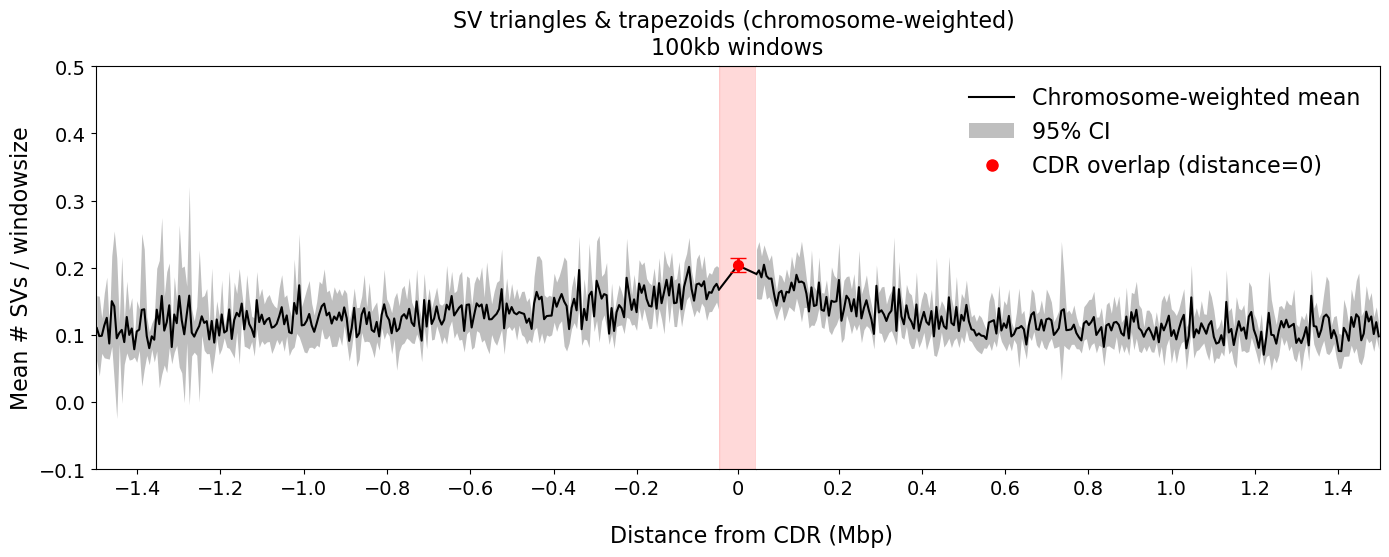

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import t
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

alpha = 0.05
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(-window_range + bin_width / 2, window_range, bin_width)
bins = np.concatenate([bin_centers - bin_width / 2, [bin_centers[-1] + bin_width / 2]])

df = SV_100kb_df[SV_100kb_df["CDR_start"] != -1].copy()
rate_col = "tri_trap_rate"
df[rate_col] = df[rate_col].replace([np.inf, -np.inf], np.nan)

df_zero = df[df["CDR_distance"] == 0].copy()
df_nonzero = df[df["CDR_distance"] != 0].copy()

df_nonzero["distance_bin"] = pd.cut(
    df_nonzero["CDR_distance"], bins=bins, labels=bin_centers, include_lowest=True
).astype(float)

win_counts = df_nonzero.groupby(["distance_bin", "chr"]).size().reset_index(name="n_windows")
valid_chrom_bins = win_counts[win_counts["n_windows"] >= 10][["distance_bin", "chr"]]

chrom_bin_means = (
    df_nonzero.merge(valid_chrom_bins, on=["distance_bin", "chr"])
    .groupby(["distance_bin", "chr"])
    .agg(chrom_mean=(rate_col, "mean"))
    .reset_index()
)

agg = (
    chrom_bin_means.groupby("distance_bin")
    .agg(mean_rate=("chrom_mean", "mean"), std_rate=("chrom_mean", "std"), n_chroms=("chrom_mean", "count"))
    .reset_index().sort_values("distance_bin")
)

agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

zero_chrom_means = df_zero.groupby("chr")[rate_col].mean()
zero_mean = zero_chrom_means.mean()
zero_n = len(zero_chrom_means)
if zero_n >= 2:
    zero_std = zero_chrom_means.std()
    zero_tcrit = t.ppf(1 - alpha / 2, zero_n - 1)
    zero_se = zero_std / np.sqrt(zero_n)
    zero_ci_low = zero_mean - zero_tcrit * zero_se
    zero_ci_high = zero_mean + zero_tcrit * zero_se
else:
    zero_ci_low = zero_ci_high = np.nan

agg_left = agg[agg["distance_bin"] < 0].copy().sort_values("distance_bin")
agg_right = agg[agg["distance_bin"] > 0].copy().sort_values("distance_bin")

# y-values at the edges closest to zero (for connecting lines)
left_edge_y = agg_left.iloc[-1]["mean_rate"]
right_edge_y = agg_right.iloc[0]["mean_rate"]

# --- 3-panel seamless plot ---
fig = plt.figure(figsize=(14, 6))
# To make the CDR box smaller, reduce the center value in width_ratios:
gs = GridSpec(1, 3, width_ratios=[5, 0.3, 5], wspace=0)  # was 0.75, try 0.4

ax_left = fig.add_subplot(gs[0])
ax_mid = fig.add_subplot(gs[1], sharey=ax_left)
ax_right = fig.add_subplot(gs[2], sharey=ax_left)

ylims = (-0.1, 0.5)

# --- Left panel ---
ax_left.plot(agg_left["distance_bin"], agg_left["mean_rate"], color="black", linewidth=1.5)
valid_l = agg_left["n_chroms"] >= 2
ax_left.fill_between(agg_left.loc[valid_l, "distance_bin"], agg_left.loc[valid_l, "ci_low"],
                      agg_left.loc[valid_l, "ci_high"], color="black", alpha=0.25, linewidth=0)
ax_left.set_xlim(-window_range, -bin_width / 2)   # was -window_range, 0
ax_left.set_ylim(*ylims)
ax_left.set_ylabel("Mean # SVs / windowsize", fontsize=16)
ax_left.tick_params(axis="both", which="major", labelsize=14)
ax_left.spines["right"].set_visible(False)
ax_left.tick_params(right=False)

# --- Center panel (zero bin, seamless) ---
ax_mid.axvspan(-1.5, 1.5, color="red", alpha=0.15)
ax_mid.plot(0, zero_mean, 'o', color="red", markersize=7, zorder=5, label="CDR overlap (distance=0)")
if not np.isnan(zero_ci_low):
    ax_mid.errorbar(0, zero_mean, yerr=[[zero_mean - zero_ci_low], [zero_ci_high - zero_mean]],
                    color="red", capsize=6, linewidth=2, zorder=5)
# Connect black lines through to the red dot
ax_mid.plot([-1.5, 0], [left_edge_y, zero_mean], color="black", linewidth=1.5, clip_on=False)
ax_mid.plot([0, 1.5], [zero_mean, right_edge_y], color="black", linewidth=1.5, clip_on=False)
ax_mid.set_xlim(-1.5, 1.5)
ax_mid.set_xticks([0])
ax_mid.set_xticklabels(["0"], fontsize=14)
ax_mid.tick_params(axis="y", labelleft=False, left=False, right=False)
ax_mid.spines["left"].set_visible(False)
ax_mid.spines["right"].set_visible(False)

# --- Right panel ---
ax_right.plot(agg_right["distance_bin"], agg_right["mean_rate"], color="black", linewidth=1.5,
              label="Chromosome-weighted mean")
valid_r = agg_right["n_chroms"] >= 2
ax_right.fill_between(agg_right.loc[valid_r, "distance_bin"], agg_right.loc[valid_r, "ci_low"],
                       agg_right.loc[valid_r, "ci_high"], color="black", alpha=0.25, linewidth=0,
                       label="95% CI")
ax_right.set_xlim(bin_width / 2, window_range)     # was 0, window_range
ax_right.tick_params(axis="y", labelleft=False, left=False)
ax_right.tick_params(axis="both", which="major", labelsize=14)
ax_right.spines["left"].set_visible(False)

cdr_proxy = Line2D([0], [0], marker='o', color='red', markersize=8, linestyle='None', label='CDR overlap (distance=0)')
handles, labels = ax_right.get_legend_handles_labels()
handles.append(cdr_proxy)
ax_right.legend(handles=handles, frameon=False, fontsize=16, loc="upper right")

# Filter out 0 ticks (use 'tick' not 't' to avoid shadowing scipy.stats.t)
left_ticks = [tick for tick in ax_left.get_xticks() if tick != 0]
ax_left.set_xticks(left_ticks)
ax_left.set_xlim(-window_range, -bin_width / 2)   # re-apply after set_xticks

right_ticks = [tick for tick in ax_right.get_xticks() if tick != 0]
ax_right.set_xticks(right_ticks)
ax_right.set_xlim(bin_width / 2, window_range)     # re-apply after set_xticks

fig.suptitle("SV triangles & trapezoids (chromosome-weighted) \n100kb windows", fontsize=16, x=0.53,y=0.9)
fig.text(0.54, 0.012, "Distance from CDR (Mbp)", ha="center", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Re-apply one more time after tight_layout, which can also adjust limits
ax_left.set_xlim(-window_range, -bin_width / 2)
ax_right.set_xlim(bin_width / 2, window_range)

ax_left.xaxis.get_offset_text().set_visible(False)
ax_right.xaxis.get_offset_text().set_visible(False)


plt.show()


### SVS per chrom

/data/tmp/ipykernel_2931764/639633702.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.01, 1, 0.93])


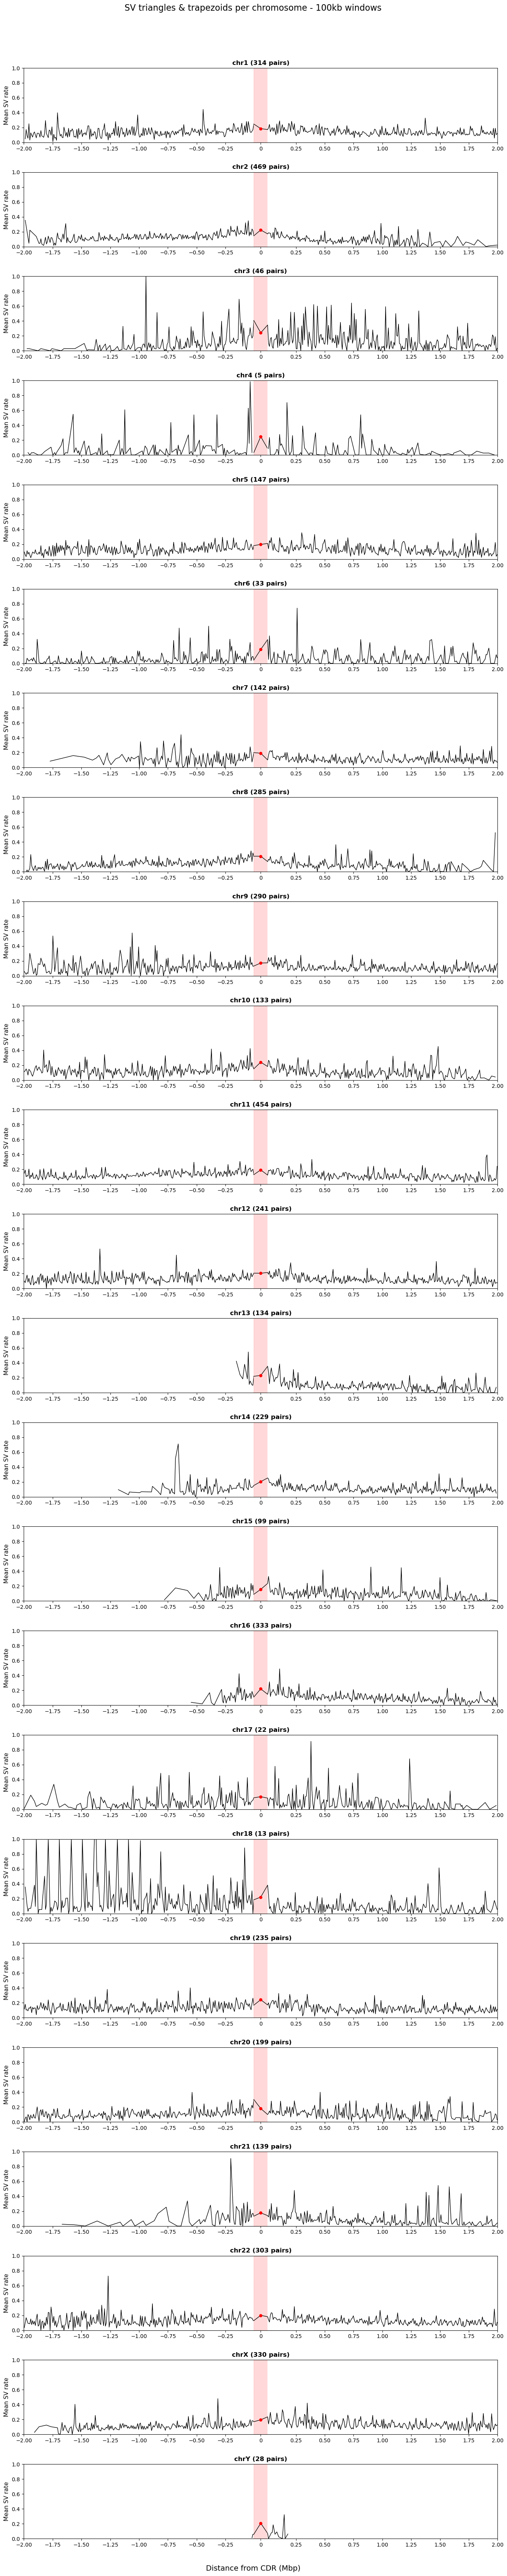

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.lines import Line2D

window_range = 2_000_000
n_bins = 500
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(-window_range + bin_width / 2, window_range, bin_width)
bins = np.concatenate([bin_centers - bin_width / 2, [bin_centers[-1] + bin_width / 2]])

df = SV_100kb_df[SV_100kb_df["CDR_start"] != -1].copy()
rate_col = "tri_trap_rate"
df[rate_col] = df[rate_col].replace([np.inf, -np.inf], np.nan)

df_zero = df[df["CDR_distance"] == 0].copy()
df_nonzero = df[df["CDR_distance"] != 0].copy()

df_nonzero["distance_bin"] = pd.cut(
    df_nonzero["CDR_distance"], bins=bins, labels=bin_centers, include_lowest=True
).astype(float)

chromosomes = sorted(df["chr"].unique(), key=lambda c: (int(c.replace("chr","")) if c.replace("chr","").isdigit() else 99, c))
n_chroms = len(chromosomes)

fig = plt.figure(figsize=(16, n_chroms * 3.5))
outer_gs = GridSpec(n_chroms, 1, figure=fig, hspace=0.4)

ylims = (0, 1.0)
all_axes = []

pair_counts = (
    df[["chr", "sample1", "sample2"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
    .to_dict()
)


for idx, chrom in enumerate(chromosomes):
    inner_gs = GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[idx],
                                       width_ratios=[5, 0.3, 5], wspace=0)

    ax_left = fig.add_subplot(inner_gs[0])
    ax_mid = fig.add_subplot(inner_gs[1], sharey=ax_left)
    ax_right = fig.add_subplot(inner_gs[2], sharey=ax_left)
    all_axes.append((ax_left, ax_mid, ax_right))

    chr_nonzero = df_nonzero[df_nonzero["chr"] == chrom]
    chr_zero = df_zero[df_zero["chr"] == chrom]

    # Aggregate per bin (no CI, no n>=2 filter)
    chr_agg = (
        chr_nonzero.groupby("distance_bin")
        .agg(mean_rate=(rate_col, "mean"))
        .reset_index().sort_values("distance_bin")
    )

    chr_left = chr_agg[chr_agg["distance_bin"] < 0].copy()
    chr_right = chr_agg[chr_agg["distance_bin"] > 0].copy()

    # Zero bin mean (no CI)
    zero_vals = chr_zero[rate_col].dropna()
    zero_mean = zero_vals.mean() if len(zero_vals) > 0 else np.nan

    # --- Left panel ---
    if len(chr_left) > 0:
        ax_left.plot(chr_left["distance_bin"], chr_left["mean_rate"], color="black", linewidth=1)
    ax_left.set_xlim(-window_range, -bin_width / 2)
    ax_left.set_ylim(*ylims)
    ax_left.spines["right"].set_visible(False)
    ax_left.tick_params(right=False, labelsize=10)
    ax_left.set_ylabel("Mean SV rate", fontsize=11)

    # --- Center panel ---
    ax_mid.axvspan(-1.5, 1.5, color="red", alpha=0.15)
    if np.isfinite(zero_mean):
        ax_mid.plot(0, zero_mean, 'o', color="red", markersize=5, zorder=5)
        left_edge_y = chr_left.iloc[-1]["mean_rate"] if len(chr_left) > 0 else np.nan
        right_edge_y = chr_right.iloc[0]["mean_rate"] if len(chr_right) > 0 else np.nan
        if np.isfinite(left_edge_y):
            ax_mid.plot([-1.5, 0], [left_edge_y, zero_mean], color="black", linewidth=1, clip_on=False)
        if np.isfinite(right_edge_y):
            ax_mid.plot([0, 1.5], [zero_mean, right_edge_y], color="black", linewidth=1, clip_on=False)
    ax_mid.set_xlim(-1.5, 1.5)
    ax_mid.set_xticks([0])
    ax_mid.set_xticklabels(["0"], fontsize=10)
    ax_mid.tick_params(axis="y", labelleft=False, left=False, right=False)
    ax_mid.spines["left"].set_visible(False)
    ax_mid.spines["right"].set_visible(False)
    n_pairs = pair_counts.get(chrom, 0)
    ax_mid.set_title(f"{chrom} ({n_pairs} pairs)", fontsize=12, fontweight="bold")


    # --- Right panel ---
    if len(chr_right) > 0:
        ax_right.plot(chr_right["distance_bin"], chr_right["mean_rate"], color="black", linewidth=1)
    ax_right.set_xlim(bin_width / 2, window_range)
    ax_right.tick_params(axis="y", labelleft=False, left=False)
    ax_right.tick_params(labelsize=10)
    ax_right.spines["left"].set_visible(False)

    # Remove 0 ticks, re-apply xlim
    left_ticks = [tick for tick in ax_left.get_xticks() if tick != 0]
    ax_left.set_xticks(left_ticks)
    ax_left.set_xlim(-window_range, -bin_width / 2)
    right_ticks = [tick for tick in ax_right.get_xticks() if tick != 0]
    ax_right.set_xticks(right_ticks)
    ax_right.set_xlim(bin_width / 2, window_range)
    ax_left.xaxis.get_offset_text().set_visible(False)
    ax_right.xaxis.get_offset_text().set_visible(False)

fig.suptitle("SV triangles & trapezoids per chromosome - 100kb windows", fontsize=16, y=0.9)
fig.text(0.5, 0.1, "Distance from CDR (Mbp)", ha="center", fontsize=14)
plt.tight_layout(rect=[0, 0.01, 1, 0.93])

for ax_left, ax_mid, ax_right in all_axes:
    ax_left.set_xlim(-window_range, -bin_width / 2)
    ax_right.set_xlim(bin_width / 2, window_range)

plt.show()

In [10]:
for chrom in sorted(SV_100kb_df["chr"].unique(), key=lambda c: (int(c.replace("chr","")) if c.replace("chr","").isdigit() else 99, c)):
    chrom_df = SV_100kb_df[SV_100kb_df["chr"] == chrom]
    all_samples = set(chrom_df["sample1"].unique()) | set(chrom_df["sample2"].unique())
    cdr_df = chrom_df[chrom_df["CDR_start"] != -1]
    cdr_samples = set(cdr_df["sample1"].unique()) | set(cdr_df["sample2"].unique())
    print(f"{chrom}: {len(cdr_samples)} with CDR / {len(all_samples)} total")


chr1: 201 with CDR / 201 total
chr2: 240 with CDR / 240 total
chr3: 39 with CDR / 39 total
chr4: 10 with CDR / 10 total
chr5: 146 with CDR / 146 total
chr6: 41 with CDR / 41 total
chr7: 138 with CDR / 138 total
chr8: 169 with CDR / 169 total
chr9: 208 with CDR / 208 total
chr10: 116 with CDR / 116 total
chr11: 257 with CDR / 257 total
chr12: 194 with CDR / 194 total
chr13: 96 with CDR / 96 total
chr14: 204 with CDR / 204 total
chr15: 93 with CDR / 93 total
chr16: 203 with CDR / 203 total
chr17: 30 with CDR / 30 total
chr18: 24 with CDR / 24 total
chr19: 185 with CDR / 185 total
chr20: 132 with CDR / 132 total
chr21: 107 with CDR / 107 total
chr22: 213 with CDR / 213 total
chrX: 189 with CDR / 189 total
chrY: 15 with CDR / 15 total


### SNVs - 10kb windows 

In [11]:
def load_matching_beds_SNVs(chr_str, bed_folder, pairs_df, suffix):

    valid_pairs = {
        frozenset((row.sample1, row.sample2))
        for _, row in pairs_df.iterrows()
    }

    col_indices = [0, 1, 2, 3, 6, 7, 8, 9,10,11,12]
    col_names = [
        "contig",
        "window_start",
        "window_end",
        "SNV_counts",
        "SNV_rate",
        "CDR_contig",
        "CDR_start",
        "CDR_end",
        "CDR_status",
        "CDR_distance",
        "aligned_bases"
    ]

    all_beds = []

    for fname in os.listdir(bed_folder):

        if not fname.endswith(suffix):
            continue

        base = fname.replace(suffix, "")
        try:
            s1, s2 = base.split("_", 1)
        except ValueError:
            continue

        if frozenset((s1, s2)) not in valid_pairs:
            continue

        bed_path = os.path.join(bed_folder, fname)

        bed_df = pd.read_csv(
            bed_path,
            sep="\t",
            header=None
        )

        #if bed_df.shape[1] <= max(col_indices):
            #print("Unexpected column count:", bed_path, bed_df.shape[1])
            #continue

        # Subset columns
        bed_df = bed_df.iloc[:, col_indices]

        if bed_df.empty:
            continue

        # Add sample metadata
        bed_df.columns = col_names
        bed_df["sample1"] = s1
        bed_df["sample2"] = s2
        bed_df["chr"]=chr_str

        # Check whether all rows have CDR_status == "CDR". Might use this to filter out pairs where one pair doesn't have CDR annotations
        # to make the counts work out 

        both_pairs_CDR = bed_df["CDR_status"].eq("CDR").all()
        bed_df["both_pairs_CDR"] = both_pairs_CDR

        all_beds.append(bed_df)

    if not all_beds:
        return pd.DataFrame()

    return pd.concat(all_beds, ignore_index=True)

In [12]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR_centrodip_02102026/aligned_bases_per_bed/SNVs_pairwise_10kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_beds_SNVs(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".aligned_bases.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
SNV_raw_100kb_df = pd.concat(all_chrom_dfs, ignore_index=True)
# Add aligned bases 
SNV_raw_100kb_df["SNV_rate_aln_bases"] = SNV_raw_100kb_df["SNV_counts"] / SNV_raw_100kb_df["aligned_bases"]

SNV_raw_100kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...
Processing chrY...


,contig,window_start,window_end,SNV_counts,SNV_rate,CDR_contig,CDR_start,CDR_end,CDR_status,CDR_distance,aligned_bases,sample1,sample2,chr,both_pairs_CDR,SNV_rate_aln_bases
0,NA19909#2#CM094132.1,121895768,121905768,9,0.0009,NA19909#2#CM094132.1,124206709,124229447,NA19909.2,2300942,7625,HG01784.1,NA19909.2,chr1,False,0.001180
1,NA19909#2#CM094132.1,121905768,121915768,4,0.0004,NA19909#2#CM094132.1,124206709,124229447,NA19909.2,2290942,10000,HG01784.1,NA19909.2,chr1,False,0.000400
2,NA19909#2#CM094132.1,121915768,121925768,8,0.0008,NA19909#2#CM094132.1,124206709,124229447,NA19909.2,2280942,9901,HG01784.1,NA19909.2,chr1,False,0.000808
3,NA19909#2#CM094132.1,121925768,121935768,7,0.0007,NA19909#2#CM094132.1,124206709,124229447,NA19909.2,2270942,7382,HG01784.1,NA19909.2,chr1,False,0.000948
4,NA19909#2#CM094132.1,121935768,121945768,10,0.0010,NA19909#2#CM094132.1,124206709,124229447,NA19909.2,2260942,6600,HG01784.1,NA19909.2,chr1,False,0.001515


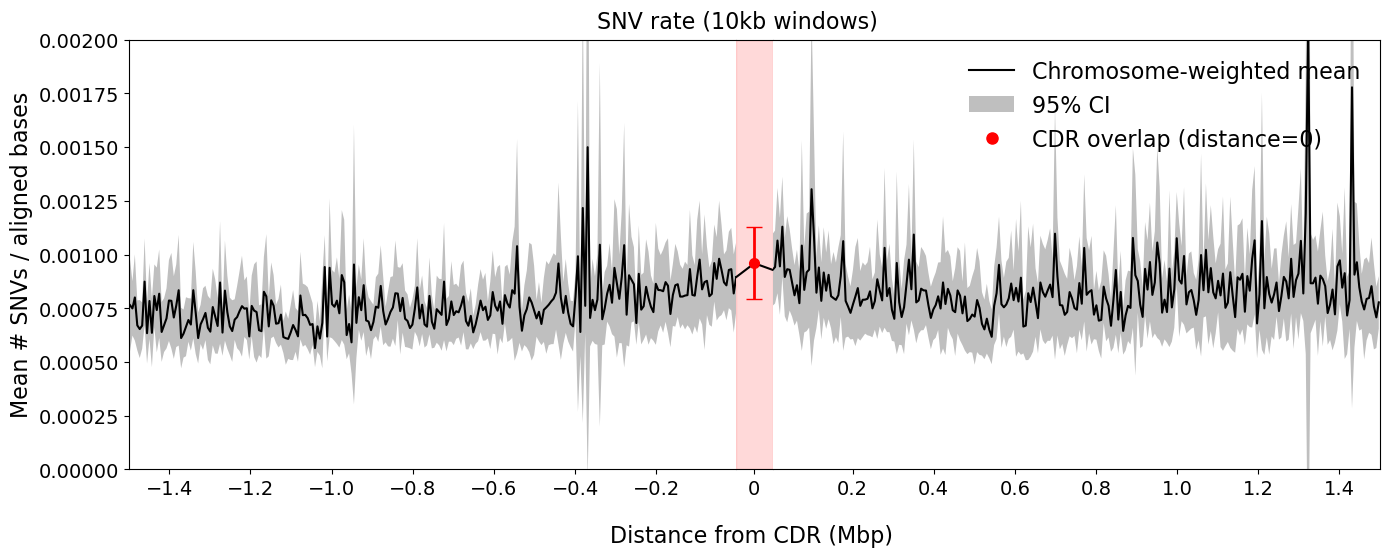

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import t
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

alpha = 0.05
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(-window_range + bin_width / 2, window_range, bin_width)
bins = np.concatenate([bin_centers - bin_width / 2, [bin_centers[-1] + bin_width / 2]])

df = SNV_raw_100kb_df[SNV_raw_100kb_df["CDR_start"] != -1].copy()
rate_col = "SNV_rate_aln_bases"

# ----------------------------
# Filter windows with <20% aligned bases
# ----------------------------
df["window_size"] = df["window_end"] - df["window_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]

df = df[df["aligned_fraction"] >= 0.2].copy()

# Clean invalid rates
df["SNV_rate_aln_bases"] = df[rate_col].replace([np.inf, -np.inf], np.nan)

# Assign numeric bin centers
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)


df_zero = df[df["CDR_distance"] == 0].copy()
df_nonzero = df[df["CDR_distance"] != 0].copy()

df_nonzero["distance_bin"] = pd.cut(
    df_nonzero["CDR_distance"], bins=bins, labels=bin_centers, include_lowest=True
).astype(float)

win_counts = df_nonzero.groupby(["distance_bin", "chr"]).size().reset_index(name="n_windows")
valid_chrom_bins = win_counts[win_counts["n_windows"] >= 10][["distance_bin", "chr"]]

chrom_bin_means = (
    df_nonzero.merge(valid_chrom_bins, on=["distance_bin", "chr"])
    .groupby(["distance_bin", "chr"])
    .agg(chrom_mean=(rate_col, "mean"))
    .reset_index()
)

agg = (
    chrom_bin_means.groupby("distance_bin")
    .agg(mean_rate=("chrom_mean", "mean"), std_rate=("chrom_mean", "std"), n_chroms=("chrom_mean", "count"))
    .reset_index().sort_values("distance_bin")
)

agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

zero_chrom_means = df_zero.groupby("chr")[rate_col].mean()
zero_mean = zero_chrom_means.mean()
zero_n = len(zero_chrom_means)
if zero_n >= 2:
    zero_std = zero_chrom_means.std()
    zero_tcrit = t.ppf(1 - alpha / 2, zero_n - 1)
    zero_se = zero_std / np.sqrt(zero_n)
    zero_ci_low = zero_mean - zero_tcrit * zero_se
    zero_ci_high = zero_mean + zero_tcrit * zero_se
else:
    zero_ci_low = zero_ci_high = np.nan

agg_left = agg[agg["distance_bin"] < 0].copy().sort_values("distance_bin")
agg_right = agg[agg["distance_bin"] > 0].copy().sort_values("distance_bin")

# y-values at the edges closest to zero (for connecting lines)
left_edge_y = agg_left.iloc[-1]["mean_rate"]
right_edge_y = agg_right.iloc[0]["mean_rate"]

# --- 3-panel seamless plot ---
fig = plt.figure(figsize=(14, 6))
# To make the CDR box smaller, reduce the center value in width_ratios:
gs = GridSpec(1, 3, width_ratios=[5, 0.3, 5], wspace=0)  # was 0.75, try 0.4

ax_left = fig.add_subplot(gs[0])
ax_mid = fig.add_subplot(gs[1], sharey=ax_left)
ax_right = fig.add_subplot(gs[2], sharey=ax_left)

ylims = (0, 0.002)

# --- Left panel ---
ax_left.plot(agg_left["distance_bin"], agg_left["mean_rate"], color="black", linewidth=1.5)
valid_l = agg_left["n_chroms"] >= 2
ax_left.fill_between(agg_left.loc[valid_l, "distance_bin"], agg_left.loc[valid_l, "ci_low"],
                      agg_left.loc[valid_l, "ci_high"], color="black", alpha=0.25, linewidth=0)
ax_left.set_xlim(-window_range, -bin_width / 2)   # was -window_range, 0
ax_left.set_ylim(*ylims)
ax_left.set_ylabel("Mean # SNVs / aligned bases", fontsize=16)
ax_left.tick_params(axis="both", which="major", labelsize=14)
ax_left.spines["right"].set_visible(False)
ax_left.tick_params(right=False)

# --- Center panel (zero bin, seamless) ---
ax_mid.axvspan(-1.5, 1.5, color="red", alpha=0.15)
ax_mid.plot(0, zero_mean, 'o', color="red", markersize=7, zorder=5, label="CDR overlap (distance=0)")
if not np.isnan(zero_ci_low):
    ax_mid.errorbar(0, zero_mean, yerr=[[zero_mean - zero_ci_low], [zero_ci_high - zero_mean]],
                    color="red", capsize=6, linewidth=2, zorder=5)
# Connect black lines through to the red dot
ax_mid.plot([-1.5, 0], [left_edge_y, zero_mean], color="black", linewidth=1.5, clip_on=False)
ax_mid.plot([0, 1.5], [zero_mean, right_edge_y], color="black", linewidth=1.5, clip_on=False)
ax_mid.set_xlim(-1.5, 1.5)
ax_mid.set_xticks([0])
ax_mid.set_xticklabels(["0"], fontsize=14)
ax_mid.tick_params(axis="y", labelleft=False, left=False, right=False)
ax_mid.spines["left"].set_visible(False)
ax_mid.spines["right"].set_visible(False)

# --- Right panel ---
ax_right.plot(agg_right["distance_bin"], agg_right["mean_rate"], color="black", linewidth=1.5,
              label="Chromosome-weighted mean")
valid_r = agg_right["n_chroms"] >= 2
ax_right.fill_between(agg_right.loc[valid_r, "distance_bin"], agg_right.loc[valid_r, "ci_low"],
                       agg_right.loc[valid_r, "ci_high"], color="black", alpha=0.25, linewidth=0,
                       label="95% CI")
ax_right.set_xlim(bin_width / 2, window_range)     # was 0, window_range
ax_right.tick_params(axis="y", labelleft=False, left=False)
ax_right.tick_params(axis="both", which="major", labelsize=14)
ax_right.spines["left"].set_visible(False)

cdr_proxy = Line2D([0], [0], marker='o', color='red', markersize=8, linestyle='None', label='CDR overlap (distance=0)')
handles, labels = ax_right.get_legend_handles_labels()
handles.append(cdr_proxy)
ax_right.legend(handles=handles, frameon=False, fontsize=16, loc="upper right")

# Filter out 0 ticks (use 'tick' not 't' to avoid shadowing scipy.stats.t)
left_ticks = [tick for tick in ax_left.get_xticks() if tick != 0]
ax_left.set_xticks(left_ticks)
ax_left.set_xlim(-window_range, -bin_width / 2)   # re-apply after set_xticks

right_ticks = [tick for tick in ax_right.get_xticks() if tick != 0]
ax_right.set_xticks(right_ticks)
ax_right.set_xlim(bin_width / 2, window_range)     # re-apply after set_xticks

fig.suptitle("SNV rate (10kb windows)", fontsize=16, x=0.53,y=0.9)
fig.text(0.54, 0.012, "Distance from CDR (Mbp)", ha="center", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Re-apply one more time after tight_layout, which can also adjust limits
ax_left.set_xlim(-window_range, -bin_width / 2)
ax_right.set_xlim(bin_width / 2, window_range)

ax_left.xaxis.get_offset_text().set_visible(False)
ax_right.xaxis.get_offset_text().set_visible(False)


plt.show()

### Short indels 10kb windows 

In [14]:
def load_matching_bed_aln(chr_str, bed_folder, pairs_df, suffix):

    valid_pairs = {
        frozenset((row.sample1, row.sample2))
        for _, row in pairs_df.iterrows()
    }

    col_indices = [0, 1, 2, 3, 4,5, 6, 7, 8, 9,10,11,12,13,14]
    col_names = [
        "SV_contig",
        "SV_start",
        "SV_end",
        "par_counts",
        "par_rate",
        "trap_counts",
        "trap_rate",
        "tri_counts",
        "tri_rate",
        "CDR_contig",
        "CDR_start",
        "CDR_end",
        "CDR_status",
        "CDR_distance",
        "aligned_bases"
    ]

    all_beds = []

    for fname in os.listdir(bed_folder):
        if not fname.endswith(suffix):
            continue

        base = fname.replace(suffix, "")
        try:
            s1, s2 = base.split("_", 1)
        except ValueError:
            continue

        if frozenset((s1, s2)) not in valid_pairs:
            continue

        bed_path = os.path.join(bed_folder, fname)

        bed_df = pd.read_csv(
            bed_path,
            sep="\t",
            header=None
        )
        #if bed_df.shape[1] <= max(col_indices):
            #print("Unexpected column count:", bed_path, bed_df.shape[1])
            #continue

        # Subset columns
        bed_df = bed_df.iloc[:, col_indices]

        if bed_df.empty:
            continue

        # Add sample metadata
        bed_df.columns = col_names
        bed_df["sample1"] = s1
        bed_df["sample2"] = s2
        bed_df["chr"]=chr_str

        # Check whether all rows have CDR_status == "CDR". Might use this to filter out pairs where one pair doesn't have CDR annotations
        # to make the counts work out 

        both_pairs_CDR = bed_df["CDR_status"].eq("CDR").all()
        bed_df["both_pairs_CDR"] = both_pairs_CDR

        all_beds.append(bed_df)

    if not all_beds:
        return pd.DataFrame()

    return pd.concat(all_beds, ignore_index=True)

In [15]:
bed_paths="/private/groups/patenlab/mira/centrolign/analysis/variant_dist_CDR_centrodip_02102026/aligned_bases_per_bed/short_indels_pairwise_10kb/"

# Define chromosomes
chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX"]
#chroms=["chrY"]
all_chrom_dfs = []

for chrom in chroms:

    # Subset pairs dataframe for this chromosome
    pairs_chr_df = all_pairs_dist_df[
        (all_pairs_dist_df["chr"] == chrom) &
        (all_pairs_dist_df["direct_pairwise_dist"] < 0.2)
    ]

    if pairs_chr_df.empty:
        continue
    
    print(f"Processing {chrom}...")
    # Load matching BED data for this chromosome

    chrom_df = load_matching_bed_aln(
        chr_str=chrom,
        bed_folder=bed_paths+chrom,
        pairs_df=pairs_chr_df,
        suffix=".aligned_bases.bed"
    )

    if not chrom_df.empty:
        chrom_df["chr"] = chrom  # optional, but often useful
        all_chrom_dfs.append(chrom_df)

# Concatenate all chromosomes into one DataFrame
short_indel_100kb_df = pd.concat(all_chrom_dfs, ignore_index=True)

short_indel_100kb_df.head()

Processing chr1...
Processing chr2...
Processing chr3...
Processing chr4...
Processing chr5...
Processing chr6...
Processing chr7...
Processing chr8...
Processing chr9...
Processing chr10...
Processing chr11...
Processing chr12...
Processing chr13...
Processing chr14...
Processing chr15...
Processing chr16...
Processing chr17...
Processing chr18...
Processing chr19...
Processing chr20...
Processing chr21...
Processing chr22...
Processing chrX...


,SV_contig,SV_start,SV_end,par_counts,par_rate,trap_counts,trap_rate,tri_counts,tri_rate,CDR_contig,CDR_start,CDR_end,CDR_status,CDR_distance,aligned_bases,sample1,sample2,chr,both_pairs_CDR
0,NA19909#2#CM094132.1,121895768,121905768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,124206709,124229447,NA19909.2,2300942,7625,HG01784.1,NA19909.2,chr1,False
1,NA19909#2#CM094132.1,121905768,121915768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,124206709,124229447,NA19909.2,2290942,10000,HG01784.1,NA19909.2,chr1,False
2,NA19909#2#CM094132.1,121915768,121925768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,124206709,124229447,NA19909.2,2280942,9901,HG01784.1,NA19909.2,chr1,False
3,NA19909#2#CM094132.1,121925768,121935768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,124206709,124229447,NA19909.2,2270942,7382,HG01784.1,NA19909.2,chr1,False
4,NA19909#2#CM094132.1,121935768,121945768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,124206709,124229447,NA19909.2,2260942,6600,HG01784.1,NA19909.2,chr1,False


In [18]:
# add rate for all variants
short_indel_100kb_df["all_counts"] = (
    short_indel_100kb_df["par_counts"]
    + short_indel_100kb_df["trap_counts"]
    + short_indel_100kb_df["tri_counts"]
)

# REVERSE CDR COORDS to match neg to upstream and pos to downstream
short_indel_100kb_df["CDR_distance"] = -short_indel_100kb_df["CDR_distance"]

short_indel_100kb_df["tri_trap_rate_aln_bases"] = (short_indel_100kb_df["tri_counts"] + short_indel_100kb_df["trap_counts"]) / short_indel_100kb_df["aligned_bases"]

short_indel_100kb_df.head()

,SV_contig,SV_start,SV_end,par_counts,par_rate,trap_counts,trap_rate,tri_counts,tri_rate,CDR_contig,...,CDR_end,CDR_status,CDR_distance,aligned_bases,sample1,sample2,chr,both_pairs_CDR,all_counts,tri_trap_rate_aln_bases
0,NA19909#2#CM094132.1,121895768,121905768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,...,124229447,NA19909.2,-2300942,7625,HG01784.1,NA19909.2,chr1,False,0,0.0
1,NA19909#2#CM094132.1,121905768,121915768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,...,124229447,NA19909.2,-2290942,10000,HG01784.1,NA19909.2,chr1,False,0,0.0
2,NA19909#2#CM094132.1,121915768,121925768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,...,124229447,NA19909.2,-2280942,9901,HG01784.1,NA19909.2,chr1,False,0,0.0
3,NA19909#2#CM094132.1,121925768,121935768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,...,124229447,NA19909.2,-2270942,7382,HG01784.1,NA19909.2,chr1,False,0,0.0
4,NA19909#2#CM094132.1,121935768,121945768,0,0.0,0,0.0,0,0.0,NA19909#2#CM094132.1,...,124229447,NA19909.2,-2260942,6600,HG01784.1,NA19909.2,chr1,False,0,0.0


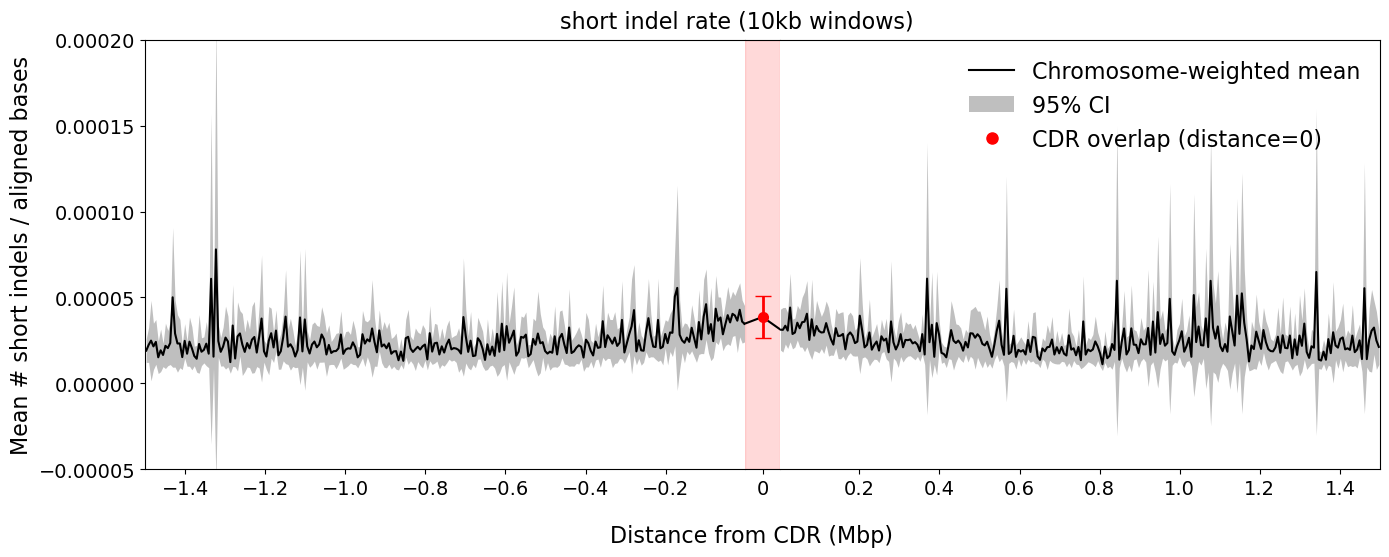

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import t
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

alpha = 0.05
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(-window_range + bin_width / 2, window_range, bin_width)
bins = np.concatenate([bin_centers - bin_width / 2, [bin_centers[-1] + bin_width / 2]])

df = short_indel_100kb_df[short_indel_100kb_df["CDR_start"] != -1].copy()
rate_col = "tri_trap_rate_aln_bases"

# ----------------------------
# Filter windows with <20% aligned bases
# ----------------------------
df["window_size"] = df["SV_end"] - df["SV_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]

df = df[df["aligned_fraction"] >= 0.2].copy()

# Clean invalid rates
df[rate_col] = df[rate_col].replace([np.inf, -np.inf], np.nan)

# Assign numeric bin centers
df["distance_bin"] = pd.cut(
    df["CDR_distance"],
    bins=bins,
    labels=bin_centers,
    include_lowest=True
).astype(float)


df_zero = df[df["CDR_distance"] == 0].copy()
df_nonzero = df[df["CDR_distance"] != 0].copy()

df_nonzero["distance_bin"] = pd.cut(
    df_nonzero["CDR_distance"], bins=bins, labels=bin_centers, include_lowest=True
).astype(float)

win_counts = df_nonzero.groupby(["distance_bin", "chr"]).size().reset_index(name="n_windows")
valid_chrom_bins = win_counts[win_counts["n_windows"] >= 10][["distance_bin", "chr"]]

chrom_bin_means = (
    df_nonzero.merge(valid_chrom_bins, on=["distance_bin", "chr"])
    .groupby(["distance_bin", "chr"])
    .agg(chrom_mean=(rate_col, "mean"))
    .reset_index()
)

agg = (
    chrom_bin_means.groupby("distance_bin")
    .agg(mean_rate=("chrom_mean", "mean"), std_rate=("chrom_mean", "std"), n_chroms=("chrom_mean", "count"))
    .reset_index().sort_values("distance_bin")
)

agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

zero_chrom_means = df_zero.groupby("chr")[rate_col].mean()
zero_mean = zero_chrom_means.mean()
zero_n = len(zero_chrom_means)
if zero_n >= 2:
    zero_std = zero_chrom_means.std()
    zero_tcrit = t.ppf(1 - alpha / 2, zero_n - 1)
    zero_se = zero_std / np.sqrt(zero_n)
    zero_ci_low = zero_mean - zero_tcrit * zero_se
    zero_ci_high = zero_mean + zero_tcrit * zero_se
else:
    zero_ci_low = zero_ci_high = np.nan

agg_left = agg[agg["distance_bin"] < 0].copy().sort_values("distance_bin")
agg_right = agg[agg["distance_bin"] > 0].copy().sort_values("distance_bin")

# y-values at the edges closest to zero (for connecting lines)
left_edge_y = agg_left.iloc[-1]["mean_rate"]
right_edge_y = agg_right.iloc[0]["mean_rate"]

# --- 3-panel seamless plot ---
fig = plt.figure(figsize=(14, 6))
# To make the CDR box smaller, reduce the center value in width_ratios:
gs = GridSpec(1, 3, width_ratios=[5, 0.3, 5], wspace=0)  # was 0.75, try 0.4

ax_left = fig.add_subplot(gs[0])
ax_mid = fig.add_subplot(gs[1], sharey=ax_left)
ax_right = fig.add_subplot(gs[2], sharey=ax_left)

ylims = (-0.00005,0.0002)

# --- Left panel ---
ax_left.plot(agg_left["distance_bin"], agg_left["mean_rate"], color="black", linewidth=1.5)
valid_l = agg_left["n_chroms"] >= 2
ax_left.fill_between(agg_left.loc[valid_l, "distance_bin"], agg_left.loc[valid_l, "ci_low"],
                      agg_left.loc[valid_l, "ci_high"], color="black", alpha=0.25, linewidth=0)
ax_left.set_xlim(-window_range, -bin_width / 2)   # was -window_range, 0
ax_left.set_ylim(*ylims)
ax_left.set_ylabel("Mean # short indels / aligned bases", fontsize=16)
ax_left.tick_params(axis="both", which="major", labelsize=14)
ax_left.spines["right"].set_visible(False)
ax_left.tick_params(right=False)

# --- Center panel (zero bin, seamless) ---
ax_mid.axvspan(-1.5, 1.5, color="red", alpha=0.15)
ax_mid.plot(0, zero_mean, 'o', color="red", markersize=7, zorder=5, label="CDR overlap (distance=0)")
if not np.isnan(zero_ci_low):
    ax_mid.errorbar(0, zero_mean, yerr=[[zero_mean - zero_ci_low], [zero_ci_high - zero_mean]],
                    color="red", capsize=6, linewidth=2, zorder=5)
# Connect black lines through to the red dot
ax_mid.plot([-1.5, 0], [left_edge_y, zero_mean], color="black", linewidth=1.5, clip_on=False)
ax_mid.plot([0, 1.5], [zero_mean, right_edge_y], color="black", linewidth=1.5, clip_on=False)
ax_mid.set_xlim(-1.5, 1.5)
ax_mid.set_xticks([0])
ax_mid.set_xticklabels(["0"], fontsize=14)
ax_mid.tick_params(axis="y", labelleft=False, left=False, right=False)
ax_mid.spines["left"].set_visible(False)
ax_mid.spines["right"].set_visible(False)

# --- Right panel ---
ax_right.plot(agg_right["distance_bin"], agg_right["mean_rate"], color="black", linewidth=1.5,
              label="Chromosome-weighted mean")
valid_r = agg_right["n_chroms"] >= 2
ax_right.fill_between(agg_right.loc[valid_r, "distance_bin"], agg_right.loc[valid_r, "ci_low"],
                       agg_right.loc[valid_r, "ci_high"], color="black", alpha=0.25, linewidth=0,
                       label="95% CI")
ax_right.set_xlim(bin_width / 2, window_range)     # was 0, window_range
ax_right.tick_params(axis="y", labelleft=False, left=False)
ax_right.tick_params(axis="both", which="major", labelsize=14)
ax_right.spines["left"].set_visible(False)

cdr_proxy = Line2D([0], [0], marker='o', color='red', markersize=8, linestyle='None', label='CDR overlap (distance=0)')
handles, labels = ax_right.get_legend_handles_labels()
handles.append(cdr_proxy)
ax_right.legend(handles=handles, frameon=False, fontsize=16, loc="upper right")

# Filter out 0 ticks (use 'tick' not 't' to avoid shadowing scipy.stats.t)
left_ticks = [tick for tick in ax_left.get_xticks() if tick != 0]
ax_left.set_xticks(left_ticks)
ax_left.set_xlim(-window_range, -bin_width / 2)   # re-apply after set_xticks

right_ticks = [tick for tick in ax_right.get_xticks() if tick != 0]
ax_right.set_xticks(right_ticks)
ax_right.set_xlim(bin_width / 2, window_range)     # re-apply after set_xticks

fig.suptitle("short indel rate (10kb windows)", fontsize=16, x=0.53,y=0.9)
fig.text(0.54, 0.012, "Distance from CDR (Mbp)", ha="center", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Re-apply one more time after tight_layout, which can also adjust limits
ax_left.set_xlim(-window_range, -bin_width / 2)
ax_right.set_xlim(bin_width / 2, window_range)

ax_left.xaxis.get_offset_text().set_visible(False)
ax_right.xaxis.get_offset_text().set_visible(False)


plt.show()

### All three types summary plots 

/data/tmp/ipykernel_2931764/3196439333.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.02, 1, 1.0])


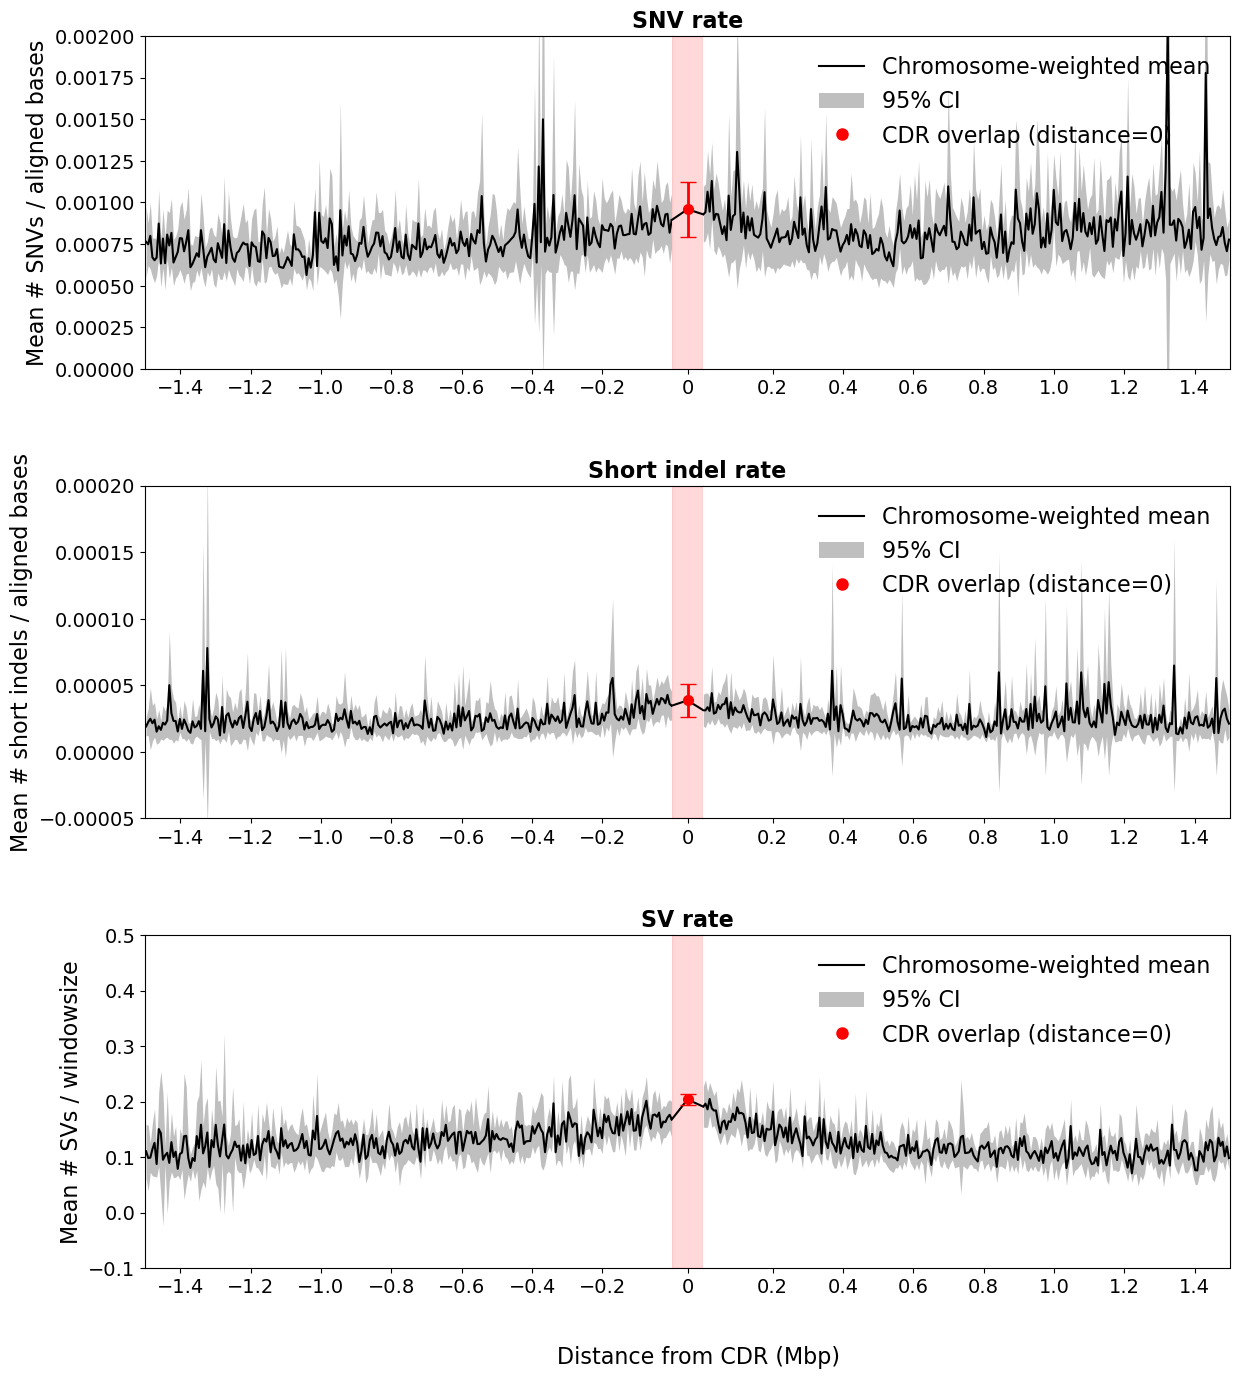

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from scipy.stats import t
from matplotlib.lines import Line2D

alpha = 0.05
window_range = 1_500_000
n_bins = 500
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(-window_range + bin_width / 2, window_range, bin_width)
bins = np.concatenate([bin_centers - bin_width / 2, [bin_centers[-1] + bin_width / 2]])

# --- Define the three variant types ---
variants = [
    {
        "source_df": SNV_raw_100kb_df,
        "rate_col": "SNV_rate_aln_bases",
        "filter_aligned": True,
        "window_cols": ("window_start", "window_end"),
        "ylims": (0, 0.002),
        "ylabel": "Mean # SNVs / aligned bases",
        "title": "SNV rate",
    },
    {
        "source_df": short_indel_100kb_df,
        "rate_col": "tri_trap_rate_aln_bases",
        "filter_aligned": True,
        "window_cols": ("SV_start", "SV_end"),
        "ylims": (-0.00005, 0.0002),
        "ylabel": "Mean # short indels / aligned bases",
        "title": "Short indel rate",
    },
    {
        "source_df": SV_100kb_df,
        "rate_col": "tri_trap_rate",
        "filter_aligned": False,
        "window_cols": None,
        "ylims": (-0.1, 0.5),
        "ylabel": "Mean # SVs / windowsize",
        "title": "SV rate",
    },
]

# --- Build figure: 3 rows, each with 3 seamless sub-panels ---
fig = plt.figure(figsize=(14, 16))
outer_gs = GridSpec(3, 1, figure=fig, hspace=0.35)
all_axes = []

for row_idx, v in enumerate(variants):
    # --- Preprocess ---
    df = v["source_df"][v["source_df"]["CDR_start"] != -1].copy()
    rate_col = v["rate_col"]
    df[rate_col] = df[rate_col].replace([np.inf, -np.inf], np.nan)

    if v["filter_aligned"]:
        wcol_start, wcol_end = v["window_cols"]
        df["window_size"] = df[wcol_end] - df[wcol_start]
        df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]
        df = df[df["aligned_fraction"] >= 0.2].copy()

    df_zero = df[df["CDR_distance"] == 0].copy()
    df_nonzero = df[df["CDR_distance"] != 0].copy()

    df_nonzero["distance_bin"] = pd.cut(
        df_nonzero["CDR_distance"], bins=bins, labels=bin_centers, include_lowest=True
    ).astype(float)

    win_counts = df_nonzero.groupby(["distance_bin", "chr"]).size().reset_index(name="n_windows")
    valid_chrom_bins = win_counts[win_counts["n_windows"] >= 10][["distance_bin", "chr"]]

    chrom_bin_means = (
        df_nonzero.merge(valid_chrom_bins, on=["distance_bin", "chr"])
        .groupby(["distance_bin", "chr"])
        .agg(chrom_mean=(rate_col, "mean"))
        .reset_index()
    )

    agg = (
        chrom_bin_means.groupby("distance_bin")
        .agg(mean_rate=("chrom_mean", "mean"), std_rate=("chrom_mean", "std"), n_chroms=("chrom_mean", "count"))
        .reset_index().sort_values("distance_bin")
    )

    agg["tcrit"] = t.ppf(1 - alpha / 2, agg["n_chroms"] - 1)
    agg["se"] = agg["std_rate"] / np.sqrt(agg["n_chroms"])
    agg["ci_low"] = agg["mean_rate"] - agg["tcrit"] * agg["se"]
    agg["ci_high"] = agg["mean_rate"] + agg["tcrit"] * agg["se"]

    zero_chrom_means = df_zero.groupby("chr")[rate_col].mean()
    zero_mean = zero_chrom_means.mean()
    zero_n = len(zero_chrom_means)
    if zero_n >= 2:
        zero_std = zero_chrom_means.std()
        zero_tcrit = t.ppf(1 - alpha / 2, zero_n - 1)
        zero_se = zero_std / np.sqrt(zero_n)
        zero_ci_low = zero_mean - zero_tcrit * zero_se
        zero_ci_high = zero_mean + zero_tcrit * zero_se
    else:
        zero_ci_low = zero_ci_high = np.nan

    agg_left = agg[agg["distance_bin"] < 0].copy().sort_values("distance_bin")
    agg_right = agg[agg["distance_bin"] > 0].copy().sort_values("distance_bin")

    left_edge_y = agg_left.iloc[-1]["mean_rate"]
    right_edge_y = agg_right.iloc[0]["mean_rate"]

    # --- 3-panel sub-grid ---
    inner_gs = GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[row_idx],
                                       width_ratios=[5, 0.3, 5], wspace=0)

    ax_left = fig.add_subplot(inner_gs[0])
    ax_mid = fig.add_subplot(inner_gs[1], sharey=ax_left)
    ax_right = fig.add_subplot(inner_gs[2], sharey=ax_left)
    all_axes.append((ax_left, ax_mid, ax_right))

    ylims = v["ylims"]

    # --- Left panel ---
    ax_left.plot(agg_left["distance_bin"], agg_left["mean_rate"], color="black", linewidth=1.5)
    valid_l = agg_left["n_chroms"] >= 2
    ax_left.fill_between(agg_left.loc[valid_l, "distance_bin"], agg_left.loc[valid_l, "ci_low"],
                          agg_left.loc[valid_l, "ci_high"], color="black", alpha=0.25, linewidth=0)
    ax_left.set_xlim(-window_range, -bin_width / 2)
    ax_left.set_ylim(*ylims)
    ax_left.set_ylabel(v["ylabel"], fontsize=16)
    ax_left.tick_params(axis="both", which="major", labelsize=14)
    ax_left.spines["right"].set_visible(False)
    ax_left.tick_params(right=False)

    # --- Center panel ---
    ax_mid.axvspan(-1.5, 1.5, color="red", alpha=0.15)
    ax_mid.plot(0, zero_mean, 'o', color="red", markersize=7, zorder=5)
    if not np.isnan(zero_ci_low):
        ax_mid.errorbar(0, zero_mean, yerr=[[zero_mean - zero_ci_low], [zero_ci_high - zero_mean]],
                        color="red", capsize=6, linewidth=2, zorder=5)
    ax_mid.plot([-1.5, 0], [left_edge_y, zero_mean], color="black", linewidth=1.5, clip_on=False)
    ax_mid.plot([0, 1.5], [zero_mean, right_edge_y], color="black", linewidth=1.5, clip_on=False)
    ax_mid.set_xlim(-1.5, 1.5)
    ax_mid.set_xticks([0])
    ax_mid.set_xticklabels(["0"], fontsize=14)
    ax_mid.tick_params(axis="y", labelleft=False, left=False, right=False)
    ax_mid.spines["left"].set_visible(False)
    ax_mid.spines["right"].set_visible(False)
    ax_mid.set_title(v["title"], fontsize=16, fontweight="bold")

    # --- Right panel ---
    ax_right.plot(agg_right["distance_bin"], agg_right["mean_rate"], color="black", linewidth=1.5,
                  label="Chromosome-weighted mean")
    valid_r = agg_right["n_chroms"] >= 2
    ax_right.fill_between(agg_right.loc[valid_r, "distance_bin"], agg_right.loc[valid_r, "ci_low"],
                           agg_right.loc[valid_r, "ci_high"], color="black", alpha=0.25, linewidth=0,
                           label="95% CI")
    ax_right.set_xlim(bin_width / 2, window_range)
    ax_right.tick_params(axis="y", labelleft=False, left=False)
    ax_right.tick_params(axis="both", which="major", labelsize=14)
    ax_right.spines["left"].set_visible(False)

    cdr_proxy = Line2D([0], [0], marker='o', color='red', markersize=8, linestyle='None', label='CDR overlap (distance=0)')
    handles, labels = ax_right.get_legend_handles_labels()
    handles.append(cdr_proxy)
    ax_right.legend(handles=handles, frameon=False, fontsize=16, loc="upper right")

    # Remove 0 ticks, re-apply xlim
    left_ticks = [tick for tick in ax_left.get_xticks() if tick != 0]
    ax_left.set_xticks(left_ticks)
    ax_left.set_xlim(-window_range, -bin_width / 2)
    right_ticks = [tick for tick in ax_right.get_xticks() if tick != 0]
    ax_right.set_xticks(right_ticks)
    ax_right.set_xlim(bin_width / 2, window_range)
    ax_left.xaxis.get_offset_text().set_visible(False)
    ax_right.xaxis.get_offset_text().set_visible(False)

fig.text(0.52, 0.05, "Distance from CDR (Mbp)", ha="center", fontsize=16)
plt.tight_layout(rect=[0, 0.02, 1, 1.0])

for ax_left, ax_mid, ax_right in all_axes:
    ax_left.set_xlim(-window_range, -bin_width / 2)
    ax_right.set_xlim(bin_width / 2, window_range)

plt.show()


### Per chrom plots 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.lines import Line2D

window_range = 2_000_000
n_bins = 500
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(-window_range + bin_width / 2, window_range, bin_width)
bins = np.concatenate([bin_centers - bin_width / 2, [bin_centers[-1] + bin_width / 2]])

df = SV_100kb_df[SV_100kb_df["CDR_start"] != -1].copy()
rate_col = "tri_trap_rate"
df[rate_col] = df[rate_col].replace([np.inf, -np.inf], np.nan)

df_zero = df[df["CDR_distance"] == 0].copy()
df_nonzero = df[df["CDR_distance"] != 0].copy()

df_nonzero["distance_bin"] = pd.cut(
    df_nonzero["CDR_distance"], bins=bins, labels=bin_centers, include_lowest=True
).astype(float)

chromosomes = sorted(df["chr"].unique(), key=lambda c: (int(c.replace("chr","")) if c.replace("chr","").isdigit() else 99, c))
n_chroms = len(chromosomes)

fig = plt.figure(figsize=(16, n_chroms * 3.5))
outer_gs = GridSpec(n_chroms, 1, figure=fig, hspace=0.4)

ylims = (0, 1.0)
all_axes = []

pair_counts = (
    df[["chr", "sample1", "sample2"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
    .to_dict()
)


for idx, chrom in enumerate(chromosomes):
    inner_gs = GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[idx],
                                       width_ratios=[5, 0.3, 5], wspace=0)

    ax_left = fig.add_subplot(inner_gs[0])
    ax_mid = fig.add_subplot(inner_gs[1], sharey=ax_left)
    ax_right = fig.add_subplot(inner_gs[2], sharey=ax_left)
    all_axes.append((ax_left, ax_mid, ax_right))

    chr_nonzero = df_nonzero[df_nonzero["chr"] == chrom]
    chr_zero = df_zero[df_zero["chr"] == chrom]

    # Aggregate per bin (no CI, no n>=2 filter)
    chr_agg = (
        chr_nonzero.groupby("distance_bin")
        .agg(mean_rate=(rate_col, "mean"))
        .reset_index().sort_values("distance_bin")
    )

    chr_left = chr_agg[chr_agg["distance_bin"] < 0].copy()
    chr_right = chr_agg[chr_agg["distance_bin"] > 0].copy()

    # Zero bin mean (no CI)
    zero_vals = chr_zero[rate_col].dropna()
    zero_mean = zero_vals.mean() if len(zero_vals) > 0 else np.nan

    # --- Left panel ---
    if len(chr_left) > 0:
        ax_left.plot(chr_left["distance_bin"], chr_left["mean_rate"], color="black", linewidth=1)
    ax_left.set_xlim(-window_range, -bin_width / 2)
    ax_left.set_ylim(*ylims)
    ax_left.spines["right"].set_visible(False)
    ax_left.tick_params(right=False, labelsize=10)
    ax_left.set_ylabel("Mean SV rate", fontsize=11)

    # --- Center panel ---
    ax_mid.axvspan(-1.5, 1.5, color="red", alpha=0.15)
    if np.isfinite(zero_mean):
        ax_mid.plot(0, zero_mean, 'o', color="red", markersize=5, zorder=5)
        left_edge_y = chr_left.iloc[-1]["mean_rate"] if len(chr_left) > 0 else np.nan
        right_edge_y = chr_right.iloc[0]["mean_rate"] if len(chr_right) > 0 else np.nan
        if np.isfinite(left_edge_y):
            ax_mid.plot([-1.5, 0], [left_edge_y, zero_mean], color="black", linewidth=1, clip_on=False)
        if np.isfinite(right_edge_y):
            ax_mid.plot([0, 1.5], [zero_mean, right_edge_y], color="black", linewidth=1, clip_on=False)
    ax_mid.set_xlim(-1.5, 1.5)
    ax_mid.set_xticks([0])
    ax_mid.set_xticklabels(["0"], fontsize=10)
    ax_mid.tick_params(axis="y", labelleft=False, left=False, right=False)
    ax_mid.spines["left"].set_visible(False)
    ax_mid.spines["right"].set_visible(False)
    n_pairs = pair_counts.get(chrom, 0)
    ax_mid.set_title(f"{chrom} ({n_pairs} pairs)", fontsize=12, fontweight="bold")


    # --- Right panel ---
    if len(chr_right) > 0:
        ax_right.plot(chr_right["distance_bin"], chr_right["mean_rate"], color="black", linewidth=1)
    ax_right.set_xlim(bin_width / 2, window_range)
    ax_right.tick_params(axis="y", labelleft=False, left=False)
    ax_right.tick_params(labelsize=10)
    ax_right.spines["left"].set_visible(False)

    # Remove 0 ticks, re-apply xlim
    left_ticks = [tick for tick in ax_left.get_xticks() if tick != 0]
    ax_left.set_xticks(left_ticks)
    ax_left.set_xlim(-window_range, -bin_width / 2)
    right_ticks = [tick for tick in ax_right.get_xticks() if tick != 0]
    ax_right.set_xticks(right_ticks)
    ax_right.set_xlim(bin_width / 2, window_range)
    ax_left.xaxis.get_offset_text().set_visible(False)
    ax_right.xaxis.get_offset_text().set_visible(False)

fig.suptitle("SV triangles & trapezoids per chromosome - 100kb windows", fontsize=16, y=0.9)
fig.text(0.5, 0.1, "Distance from CDR (Mbp)", ha="center", fontsize=14)
plt.tight_layout(rect=[0, 0.01, 1, 0.93])

for ax_left, ax_mid, ax_right in all_axes:
    ax_left.set_xlim(-window_range, -bin_width / 2)
    ax_right.set_xlim(bin_width / 2, window_range)

plt.show()

/data/tmp/ipykernel_3196375/2476229712.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.01, 1, 0.93])


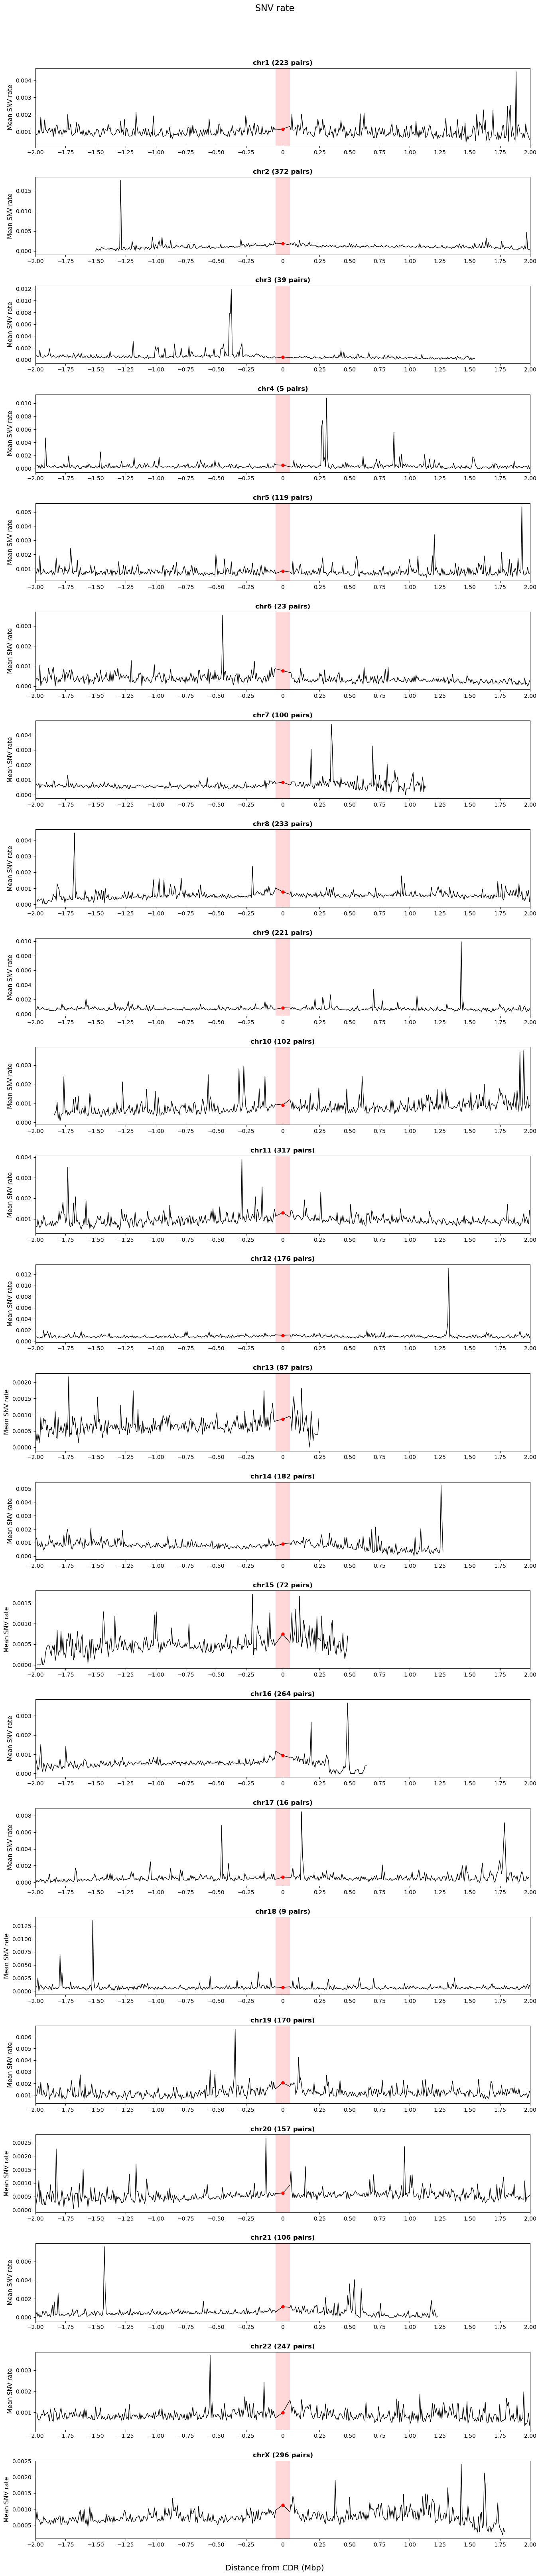

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.lines import Line2D

window_range = 2_000_000
n_bins = 500
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(-window_range + bin_width / 2, window_range, bin_width)
bins = np.concatenate([bin_centers - bin_width / 2, [bin_centers[-1] + bin_width / 2]])

df = SNV_raw_100kb_df[SNV_raw_100kb_df["CDR_start"] != -1].copy()
rate_col = "SNV_rate_aln_bases"
df[rate_col] = df[rate_col].replace([np.inf, -np.inf], np.nan)

# ----------------------------
# Filter windows with <20% aligned bases
# ----------------------------
df["window_size"] = df["window_end"] - df["window_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]

df = df[df["aligned_fraction"] >= 0.2].copy()


df_zero = df[df["CDR_distance"] == 0].copy()
df_nonzero = df[df["CDR_distance"] != 0].copy()

df_nonzero["distance_bin"] = pd.cut(
    df_nonzero["CDR_distance"], bins=bins, labels=bin_centers, include_lowest=True
).astype(float)

chromosomes = sorted(df["chr"].unique(), key=lambda c: (int(c.replace("chr","")) if c.replace("chr","").isdigit() else 99, c))
n_chroms = len(chromosomes)

fig = plt.figure(figsize=(16, n_chroms * 3.5))
outer_gs = GridSpec(n_chroms, 1, figure=fig, hspace=0.4)

#ylims = (0, 1.0)
all_axes = []

pair_counts = (
    df[["chr", "sample1", "sample2"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
    .to_dict()
)


for idx, chrom in enumerate(chromosomes):
    inner_gs = GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[idx],
                                       width_ratios=[5, 0.3, 5], wspace=0)

    ax_left = fig.add_subplot(inner_gs[0])
    ax_mid = fig.add_subplot(inner_gs[1], sharey=ax_left)
    ax_right = fig.add_subplot(inner_gs[2], sharey=ax_left)
    all_axes.append((ax_left, ax_mid, ax_right))

    chr_nonzero = df_nonzero[df_nonzero["chr"] == chrom]
    chr_zero = df_zero[df_zero["chr"] == chrom]

    # Aggregate per bin (no CI, no n>=2 filter)
    chr_agg = (
        chr_nonzero.groupby("distance_bin")
        .agg(mean_rate=(rate_col, "mean"))
        .reset_index().sort_values("distance_bin")
    )

    chr_left = chr_agg[chr_agg["distance_bin"] < 0].copy()
    chr_right = chr_agg[chr_agg["distance_bin"] > 0].copy()

    # Zero bin mean (no CI)
    zero_vals = chr_zero[rate_col].dropna()
    zero_mean = zero_vals.mean() if len(zero_vals) > 0 else np.nan

    # --- Left panel ---
    if len(chr_left) > 0:
        ax_left.plot(chr_left["distance_bin"], chr_left["mean_rate"], color="black", linewidth=1)
    ax_left.set_xlim(-window_range, -bin_width / 2)
    #ax_left.set_ylim(*ylims)
    ax_left.spines["right"].set_visible(False)
    ax_left.tick_params(right=False, labelsize=10)
    ax_left.set_ylabel("Mean SNV rate", fontsize=11)

    # --- Center panel ---
    ax_mid.axvspan(-1.5, 1.5, color="red", alpha=0.15)
    if np.isfinite(zero_mean):
        ax_mid.plot(0, zero_mean, 'o', color="red", markersize=5, zorder=5)
        left_edge_y = chr_left.iloc[-1]["mean_rate"] if len(chr_left) > 0 else np.nan
        right_edge_y = chr_right.iloc[0]["mean_rate"] if len(chr_right) > 0 else np.nan
        if np.isfinite(left_edge_y):
            ax_mid.plot([-1.5, 0], [left_edge_y, zero_mean], color="black", linewidth=1, clip_on=False)
        if np.isfinite(right_edge_y):
            ax_mid.plot([0, 1.5], [zero_mean, right_edge_y], color="black", linewidth=1, clip_on=False)
    ax_mid.set_xlim(-1.5, 1.5)
    ax_mid.set_xticks([0])
    ax_mid.set_xticklabels(["0"], fontsize=10)
    ax_mid.tick_params(axis="y", labelleft=False, left=False, right=False)
    ax_mid.spines["left"].set_visible(False)
    ax_mid.spines["right"].set_visible(False)
    n_pairs = pair_counts.get(chrom, 0)
    ax_mid.set_title(f"{chrom} ({n_pairs} pairs)", fontsize=12, fontweight="bold")


    # --- Right panel ---
    if len(chr_right) > 0:
        ax_right.plot(chr_right["distance_bin"], chr_right["mean_rate"], color="black", linewidth=1)
    ax_right.set_xlim(bin_width / 2, window_range)
    ax_right.tick_params(axis="y", labelleft=False, left=False)
    ax_right.tick_params(labelsize=10)
    ax_right.spines["left"].set_visible(False)

    # Remove 0 ticks, re-apply xlim
    left_ticks = [tick for tick in ax_left.get_xticks() if tick != 0]
    ax_left.set_xticks(left_ticks)
    ax_left.set_xlim(-window_range, -bin_width / 2)
    right_ticks = [tick for tick in ax_right.get_xticks() if tick != 0]
    ax_right.set_xticks(right_ticks)
    ax_right.set_xlim(bin_width / 2, window_range)
    ax_left.xaxis.get_offset_text().set_visible(False)
    ax_right.xaxis.get_offset_text().set_visible(False)

fig.suptitle("SNV rate", fontsize=16, y=0.9)
fig.text(0.5, 0.1, "Distance from CDR (Mbp)", ha="center", fontsize=14)
plt.tight_layout(rect=[0, 0.01, 1, 0.93])

for ax_left, ax_mid, ax_right in all_axes:
    ax_left.set_xlim(-window_range, -bin_width / 2)
    ax_right.set_xlim(bin_width / 2, window_range)

plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.lines import Line2D

window_range = 2_000_000
n_bins = 500
bin_width = (2 * window_range) / n_bins

bin_centers = np.arange(-window_range + bin_width / 2, window_range, bin_width)
bins = np.concatenate([bin_centers - bin_width / 2, [bin_centers[-1] + bin_width / 2]])

df = SNV_raw_100kb_df[SNV_raw_100kb_df["CDR_start"] != -1].copy()
rate_col = "SNV_rate_aln_bases"
df[rate_col] = df[rate_col].replace([np.inf, -np.inf], np.nan)

# ----------------------------
# Filter windows with <20% aligned bases
# ----------------------------
df["window_size"] = df["window_end"] - df["window_start"]
df["aligned_fraction"] = df["aligned_bases"] / df["window_size"]

df = df[df["aligned_fraction"] >= 0.2].copy()


df_zero = df[df["CDR_distance"] == 0].copy()
df_nonzero = df[df["CDR_distance"] != 0].copy()

df_nonzero["distance_bin"] = pd.cut(
    df_nonzero["CDR_distance"], bins=bins, labels=bin_centers, include_lowest=True
).astype(float)

chromosomes = sorted(df["chr"].unique(), key=lambda c: (int(c.replace("chr","")) if c.replace("chr","").isdigit() else 99, c))
n_chroms = len(chromosomes)

fig = plt.figure(figsize=(16, n_chroms * 3.5))
outer_gs = GridSpec(n_chroms, 1, figure=fig, hspace=0.4)

#ylims = (0, 1.0)
all_axes = []

pair_counts = (
    df[["chr", "sample1", "sample2"]]
    .drop_duplicates()
    .groupby("chr")
    .size()
    .to_dict()
)


for idx, chrom in enumerate(chromosomes):
    inner_gs = GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_gs[idx],
                                       width_ratios=[5, 0.3, 5], wspace=0)

    ax_left = fig.add_subplot(inner_gs[0])
    ax_mid = fig.add_subplot(inner_gs[1], sharey=ax_left)
    ax_right = fig.add_subplot(inner_gs[2], sharey=ax_left)
    all_axes.append((ax_left, ax_mid, ax_right))

    chr_nonzero = df_nonzero[df_nonzero["chr"] == chrom]
    chr_zero = df_zero[df_zero["chr"] == chrom]

    # Aggregate per bin (no CI, no n>=2 filter)
    chr_agg = (
        chr_nonzero.groupby("distance_bin")
        .agg(mean_rate=(rate_col, "mean"))
        .reset_index().sort_values("distance_bin")
    )

    chr_left = chr_agg[chr_agg["distance_bin"] < 0].copy()
    chr_right = chr_agg[chr_agg["distance_bin"] > 0].copy()

    # Zero bin mean (no CI)
    zero_vals = chr_zero[rate_col].dropna()
    zero_mean = zero_vals.mean() if len(zero_vals) > 0 else np.nan

    # --- Left panel ---
    if len(chr_left) > 0:
        ax_left.plot(chr_left["distance_bin"], chr_left["mean_rate"], color="black", linewidth=1)
    ax_left.set_xlim(-window_range, -bin_width / 2)
    #ax_left.set_ylim(*ylims)
    ax_left.spines["right"].set_visible(False)
    ax_left.tick_params(right=False, labelsize=10)
    ax_left.set_ylabel("Mean SNV rate", fontsize=11)

    # --- Center panel ---
    ax_mid.axvspan(-1.5, 1.5, color="red", alpha=0.15)
    if np.isfinite(zero_mean):
        ax_mid.plot(0, zero_mean, 'o', color="red", markersize=5, zorder=5)
        left_edge_y = chr_left.iloc[-1]["mean_rate"] if len(chr_left) > 0 else np.nan
        right_edge_y = chr_right.iloc[0]["mean_rate"] if len(chr_right) > 0 else np.nan
        if np.isfinite(left_edge_y):
            ax_mid.plot([-1.5, 0], [left_edge_y, zero_mean], color="black", linewidth=1, clip_on=False)
        if np.isfinite(right_edge_y):
            ax_mid.plot([0, 1.5], [zero_mean, right_edge_y], color="black", linewidth=1, clip_on=False)
    ax_mid.set_xlim(-1.5, 1.5)
    ax_mid.set_xticks([0])
    ax_mid.set_xticklabels(["0"], fontsize=10)
    ax_mid.tick_params(axis="y", labelleft=False, left=False, right=False)
    ax_mid.spines["left"].set_visible(False)
    ax_mid.spines["right"].set_visible(False)
    n_pairs = pair_counts.get(chrom, 0)
    ax_mid.set_title(f"{chrom} ({n_pairs} pairs)", fontsize=12, fontweight="bold")


    # --- Right panel ---
    if len(chr_right) > 0:
        ax_right.plot(chr_right["distance_bin"], chr_right["mean_rate"], color="black", linewidth=1)
    ax_right.set_xlim(bin_width / 2, window_range)
    ax_right.tick_params(axis="y", labelleft=False, left=False)
    ax_right.tick_params(labelsize=10)
    ax_right.spines["left"].set_visible(False)

    # Remove 0 ticks, re-apply xlim
    left_ticks = [tick for tick in ax_left.get_xticks() if tick != 0]
    ax_left.set_xticks(left_ticks)
    ax_left.set_xlim(-window_range, -bin_width / 2)
    right_ticks = [tick for tick in ax_right.get_xticks() if tick != 0]
    ax_right.set_xticks(right_ticks)
    ax_right.set_xlim(bin_width / 2, window_range)
    ax_left.xaxis.get_offset_text().set_visible(False)
    ax_right.xaxis.get_offset_text().set_visible(False)

fig.suptitle("SNV rate", fontsize=16, y=0.9)
fig.text(0.5, 0.1, "Distance from CDR (Mbp)", ha="center", fontsize=14)
plt.tight_layout(rect=[0, 0.01, 1, 0.93])

for ax_left, ax_mid, ax_right in all_axes:
    ax_left.set_xlim(-window_range, -bin_width / 2)
    ax_right.set_xlim(bin_width / 2, window_range)

plt.show()